In [13]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp
from collections import Counter

In [ ]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_y():
    """Pauli Y matrix."""
    return np.array([[0, -1j], [1j, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 2), (0, 4), (0, 5), (0, 8), (0, 9),
        (1, 3), (1, 6), (1, 7), (1, 10), (1, 11),
        (2, 6), (2, 7), (2, 8), (2, 9), (3, 4),
        (3, 5), (3, 10), (3, 11), (4, 5), (4, 8),
        (4, 10), (5, 9), (5, 11), (6, 7), (6, 8),
        (6, 10), (7, 9), (7, 11), (8, 10), (9, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Y = csr_matrix(pauli_y())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        termp = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
                termp = kron(termp, Y, format="csr")
            else:
                term = kron(term, I, format="csr")
                termp = kron(termp, I, format="csr")
        H += J * (term + termp)
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat

def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, subsystem, [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, subsystem, [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy


def entanglement_entropy_qutip(psi, subsystem, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, subsystem)
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [15]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

keep_qubits = [0, 4, 5]
#keep_qubits = [0, 4, 5, 11] # 4 spins rdm full rank
#keep_qubits = [0, 4, 5, 9]  # 4 spins - 2 adjacent triangular plaquettes - this is when i observe exactly 5 degenerate scars
#keep_qubits = [3, 5, 7, 9, 11]  # 5 spins - 3 adjacent triangular plaquettes
#keep_qubits = [0, 4, 5, 9, 11]  # 5 spins - 3 adjacent triangular plaquettes
#keep_qubits = [2, 8, 4, 5, 9] # 5 spins - pentagon around 0



# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

# Define the C5 permutation mapping for your case - around axis through vert 9 and 10
perm = {
    0: 2,
    2: 7,
    7: 11,
    11: 5,
    5: 0,
    1: 3,
    3: 4,
    4: 8,
    8: 6,
    6: 1,
    9: 9,   # Fixed
    10: 10  # Fixed
}

In [16]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

Eigenvalues of H: [-36.         -34.47213595 -34.47213595 ...  41.97565898  42.45573699
  43.15021801]


In [17]:
##################### RDMS + EE #################################

In [18]:
'''# rdm - qutip

min_eigenvalues = []
min_rdms = []
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()
    # Check if the rank is not full and print it
    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)
    if rank < traced_out_density_matrix_dense.shape[0]:
        print(f"Traced-out density matrix rank: {rank}")
    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
      min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
      rdm_eigenvalues.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms# Define the threshold - qutip
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - qutip
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]
print(f'Indices of red points: {red_indices}')

red_eigenvectors = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms[i])}')
    red_eigenvectors.append(eigenvectors[:, ind])

for i in range(len(red_indices)):
    for j in range(len(red_indices)):
        idx1, idx2 = red_indices[i], red_indices[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] - eigenvalues of the scarred rdms - that are non-zero
counts = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts}')'''

'# rdm - qutip\n\nmin_eigenvalues = []\nmin_rdms = []\nrdm_eigenvalues = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n    # Convert the result back to a dense matrix if needed\n    traced_out_density_matrix_dense = traced_out_density_matrix.full()\n    # Check if the rank is not full and print it\n    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)\n    if rank < traced_out_density_matrix_dense.shape[0]:\n        print(f"Traced-out density matrix rank: {rank}")\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)\n\n    # Find the minimum eigenv

  0%|          | 0/4096 [00:00<?, ?it/s]

100%|██████████| 4096/4096 [30:10<00:00,  2.26it/s]


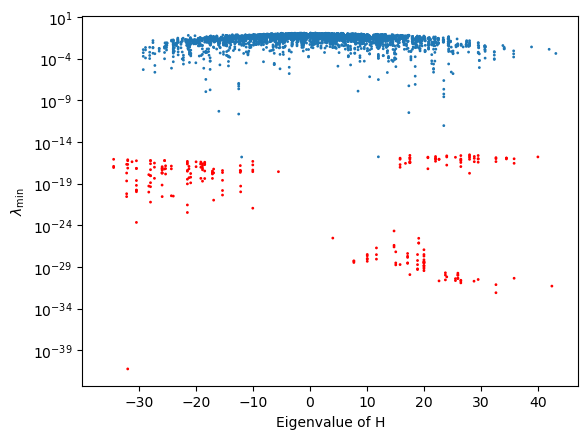

Indices of red points: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 52, 53, 54, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 76, 77, 78, 83, 84, 85, 96, 97, 98, 111, 168, 169, 170, 171, 172, 173, 174, 175, 176, 190, 191, 192, 217, 218, 219, 250, 251, 279, 280, 281, 282, 296, 297, 298, 299, 300, 311, 312, 313, 314, 315, 382, 383, 384, 385, 386, 396, 397, 398, 487, 488, 489, 490, 491, 733, 734, 735, 740, 741, 742, 945, 946, 947, 948, 949, 1401, 2563, 2943, 2944, 2945, 3178, 3179, 3180, 3181, 3182, 3302, 3303, 3304, 3554, 3555, 3556, 3569, 3570, 3571, 3614, 3615, 3616, 3617, 3618, 3664, 3683, 3684, 3685, 3686, 3687, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3850, 3851, 3852, 3903, 3904, 3905, 3906, 3907, 3927, 3928, 3929, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 

In [19]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

#for i in range(len(red_indices_np)):
#    for j in range(len(red_indices_np)):
#        idx1, idx2 = red_indices_np[i], red_indices_np[j]
#        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
#        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

In [20]:
# Check for degenerate eigenvalues with multiplicity 5 among the scarred eigenstates

# Get the eigenvalues corresponding to the scarred (red) eigenvectors
scarred_eigenvalues = np.array([eigenvalues[i] for i in red_indices_np])

# Count the multiplicity of each unique eigenvalue (within a numerical tolerance)
unique_vals, counts = np.unique(np.round(scarred_eigenvalues, decimals=10), return_counts=True)

# Print eigenvalues with multiplicity 5
print("Scarred eigenvalues with multiplicity 5:")
for val, count in zip(unique_vals, counts):
    if count == 5:
        print(f"Eigenvalue: {val}, Multiplicity: {count}")

# Optionally, print all scarred eigenvalues and their multiplicities
print("\nAll scarred eigenvalues and their multiplicities:")
for val, count in zip(unique_vals, counts):
    print(f"Eigenvalue: {val}, Multiplicity: {count}")

Scarred eigenvalues with multiplicity 5:
Eigenvalue: -32.188684504, Multiplicity: 5
Eigenvalue: -32.0, Multiplicity: 5
Eigenvalue: -25.9676737017, Multiplicity: 5
Eigenvalue: -25.9524209335, Multiplicity: 5
Eigenvalue: -18.8712068046, Multiplicity: 5
Eigenvalue: -18.4826648152, Multiplicity: 5
Eigenvalue: -17.1287931954, Multiplicity: 5
Eigenvalue: -15.3609769791, Multiplicity: 5
Eigenvalue: -10.0475790665, Multiplicity: 5
Eigenvalue: 10.0475790665, Multiplicity: 5
Eigenvalue: 15.811315496, Multiplicity: 5
Eigenvalue: 17.1287931954, Multiplicity: 5
Eigenvalue: 18.8712068046, Multiplicity: 5
Eigenvalue: 22.0323262983, Multiplicity: 5
Eigenvalue: 25.9524209335, Multiplicity: 5
Eigenvalue: 28.0, Multiplicity: 5
Eigenvalue: 29.5173351848, Multiplicity: 5
Eigenvalue: 32.6390230209, Multiplicity: 5

All scarred eigenvalues and their multiplicities:
Eigenvalue: -36.0, Multiplicity: 1
Eigenvalue: -34.472135955, Multiplicity: 3
Eigenvalue: -32.188684504, Multiplicity: 5
Eigenvalue: -32.0, Multi

In [21]:
'''# rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])
    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy()) # store the eigenvalues of the scarred rdms

# Define the threshold
threshold = 1e-16
min_eigenvalues_to = np.array(min_eigenvalues_to)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_to if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_to]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_to), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - torch
red_indices_to = [i for i, y in enumerate(min_eigenvalues_to) if y < threshold]
print(f'Indices of red points: {red_indices_to}')

red_eigenvectors_to = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_to):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_to[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_to[i])}')
    red_eigenvectors_to.append(eigenvectors[:, ind])

for i in range(len(red_indices_to)):
    for j in range(len(red_indices_to)):
        idx1, idx2 = red_indices_to[i], red_indices_to[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_to[i] - eigenvalues of the scarred rdms - that are non-zero
counts_to = [np.sum(eigenvalues > 1e-15) for eigenvalues in rdm_eigenvalues_to]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_to}')'''

'# rdm - torch\n\nmin_eigenvalues_to = []\nmin_rdms_to = []\nrdm_eigenvalues_to = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)\n    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])\n    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 \n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)\n\n    # Find the minimum eigenvalue of the traced-out density matrix\n    min_eigenvalue = torch.min(eigenvalues_traced).item()\n    min_eigenvalues_

In [ ]:
half_v = [0,2,4,5,8,9]
half_h = [0,2,5,7,9,11]

half = half_h

In [ ]:
# Generate random complex coefficients
random_coeffs = np.random.rand(len(red_indices_np)) + 1j* np.random.rand(len(red_indices_np))

# Normalize the coefficients
random_coeffs /= np.linalg.norm(random_coeffs)
print(random_coeffs)

print("coeffs norm",sum(np.abs(random_coeffs)**2))

# Define random scar state from 5 scarred states using random coefficients
rnd_scar = np.sum(eigenvectors[:, red_indices_np] * random_coeffs, axis=1)

print(len(rnd_scar))

# Save eigenvalues corresponding to red indices into a numpy array
red_eigenvalues = np.array([eigenvalues[i] for i in red_indices_np])

# Count the number of zero entries
num_zeros = np.count_nonzero((rnd_scar.real < 1e-16) & (rnd_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')

# RANDOM SCAR - RANDOM LINEAR COMBINATION OF SCARRED STATES

rnd_scar = linear_combination_np(random_coeffs, red_eigenvectors_np)
rnd_scar_entropy = entanglement_entropy(rnd_scar, half, N)
#rnd_scar_entropy_qutip = entanglement_entropy_qutip(rnd_scar, half, N)
#rnd_scar_entropy_torch = entanglement_entropy_torch(rnd_scar, half, N)
print("Random scar coeffs", random_coeffs)
print(f"Entanglement entropy of random scar state: {rnd_scar_entropy}")
#print(f"Entanglement entropy of random scar state (Qutip): {rnd_scar_entropy_qutip}")
#print(f"Entanglement entropy of random scar state (PyTorch): {rnd_scar_entropy_torch}")

[0.01566844+3.40416329e-02j 0.04345896+7.20868067e-02j
 0.05803631+7.53382020e-02j 0.05166684+5.50300571e-02j
 0.04075263+1.64604547e-02j 0.01526484+7.89028560e-02j
 0.04181532+5.39593365e-02j 0.04168812+7.94309368e-02j
 0.00556233+4.60704056e-02j 0.04297015+5.00069843e-02j
 0.00271394+6.20136613e-02j 0.06323276+5.23590072e-02j
 0.07234184+6.88589332e-02j 0.02630249+4.23070276e-02j
 0.0643674 +5.07611543e-02j 0.04773358+1.92509850e-02j
 0.0334983 +4.65746596e-02j 0.05307589+1.02523956e-02j
 0.03818026+7.35768471e-02j 0.00178087+5.18425696e-02j
 0.04142901+6.32279205e-03j 0.02438838+3.52392984e-02j
 0.00864302+5.33440224e-02j 0.02307831+7.88731953e-02j
 0.06469984+6.38940735e-02j 0.04992279+3.55708906e-02j
 0.04262008+8.99737557e-03j 0.04977922+3.28877404e-02j
 0.07495068+1.80537195e-02j 0.00406467+5.12051880e-02j
 0.03983474+5.58222317e-02j 0.02766452+4.29782230e-02j
 0.01679965+1.06775452e-02j 0.03070553+3.83064727e-02j
 0.02314903+7.90957605e-02j 0.05842176+7.87876078e-02j
 0.0706561

In [ ]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]
#qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]
#torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]

  0%|          | 0/4096 [00:00<?, ?it/s]

100%|██████████| 4096/4096 [20:55<00:00,  3.26it/s]


Entropies of red points:
Index: 0, Entropy: -0.0
Index: 1, Entropy: 0.579496317027361
Index: 2, Entropy: 0.9230825126353729
Index: 3, Entropy: 0.8812908992306969
Index: 4, Entropy: 1.8923685272778596
Index: 5, Entropy: 1.864764159207797
Index: 6, Entropy: 2.013758108075627
Index: 7, Entropy: 1.7996726413551054
Index: 8, Entropy: 1.957685395406418
Index: 9, Entropy: 0.546983763918942
Index: 10, Entropy: 0.7597901584429568
Index: 11, Entropy: 0.4689955935892863
Index: 12, Entropy: 0.9856505129035418
Index: 13, Entropy: 0.8326862374013623
Index: 14, Entropy: 2.282352846193901
Index: 15, Entropy: 2.202954114028784
Index: 16, Entropy: 2.206174797038872
Index: 17, Entropy: 2.223718467775738
Index: 18, Entropy: 1.6460004446032859
Index: 19, Entropy: 2.1662926548284167
Index: 20, Entropy: 2.4087880914900373
Index: 21, Entropy: 2.2992734603213894
Index: 22, Entropy: 2.106720120251035
Index: 23, Entropy: 1.957742805853812
Index: 31, Entropy: 3.1592596517742297
Index: 32, Entropy: 3.1747596843541

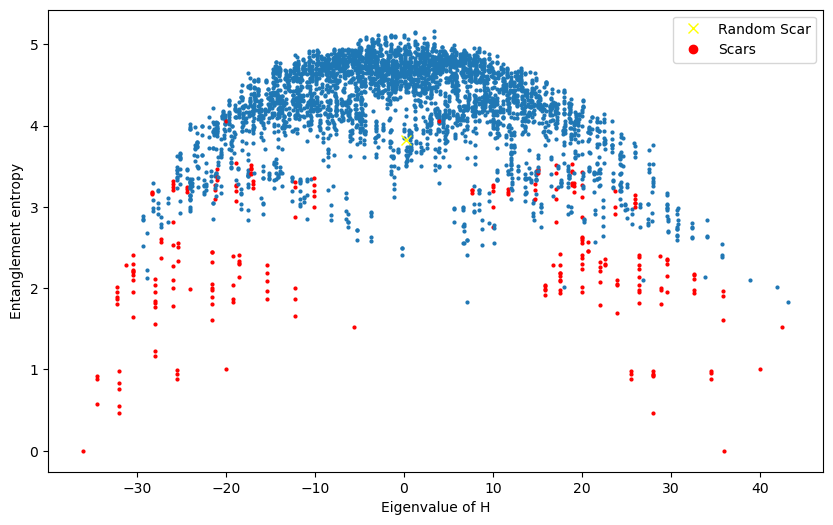

In [24]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

Entropies of red points:
Index: 0, Entropy: -0.0
Index: 1, Entropy: 0.579496317027361
Index: 2, Entropy: 0.9230825126353729
Index: 3, Entropy: 0.8812908992306969
Index: 4, Entropy: 1.8923685272778596
Index: 5, Entropy: 1.864764159207797
Index: 6, Entropy: 2.013758108075627
Index: 7, Entropy: 1.7996726413551054
Index: 8, Entropy: 1.957685395406418
Index: 9, Entropy: 0.546983763918942
Index: 10, Entropy: 0.7597901584429568
Index: 11, Entropy: 0.4689955935892863
Index: 12, Entropy: 0.9856505129035418
Index: 13, Entropy: 0.8326862374013623
Index: 14, Entropy: 2.282352846193901
Index: 15, Entropy: 2.202954114028784
Index: 16, Entropy: 2.206174797038872
Index: 17, Entropy: 2.223718467775738
Index: 18, Entropy: 1.6460004446032859
Index: 19, Entropy: 2.1662926548284167
Index: 20, Entropy: 2.4087880914900373
Index: 21, Entropy: 2.2992734603213894
Index: 22, Entropy: 2.106720120251035
Index: 23, Entropy: 1.957742805853812
Index: 31, Entropy: 3.1592596517742297
Index: 32, Entropy: 3.1747596843541

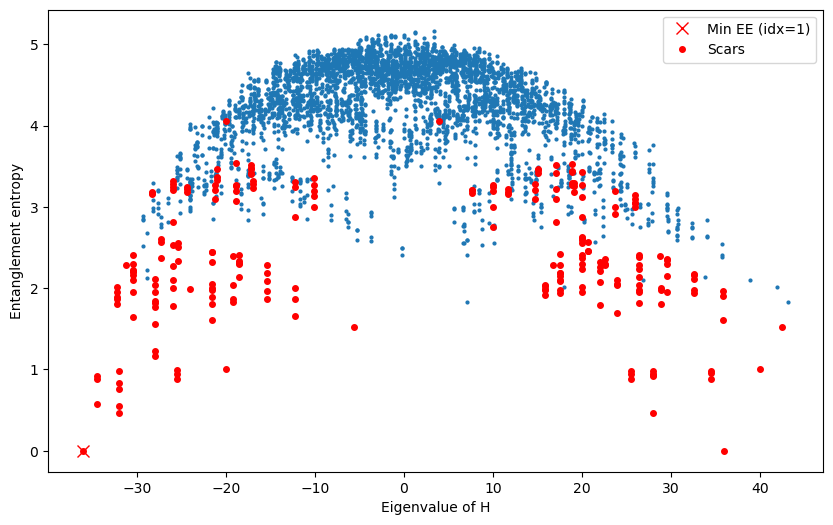

In [25]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

# Find the red index with the lowest entanglement entropy
min_entropy_idx = min(red_indices_np, key=lambda i: numpy_entropies[i])
min_entropy_val = numpy_entropies[min_entropy_idx]

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot blue points first
for i, color in enumerate(colors):
    if color != 'red':
        plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)
# Then plot red points on top
for i, color in enumerate(colors):
    if color == 'red':
        plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=4)

# Plot entanglement entropy with highlighted points
#for i, color in enumerate(colors):
#    size = 3 if color == 'red' else 2
#    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=size)

# Mark the scar with the lowest entanglement entropy with a yellow cross
plt.plot(eigenvalues[min_entropy_idx], min_entropy_val, 'x', color='red', markersize=8, label=f'Min EE (idx={min_entropy_idx + 1})')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', markersize=4, label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

In [26]:
'''# Compute entanglement entropy for the rnd_scar wavefunction - qutip

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {qutip_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_qutip}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], qutip_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

'# Compute entanglement entropy for the rnd_scar wavefunction - qutip\n\n# Print entropies of red points only\nprint("Entropies of red points:")\nfor i in red_indices:\n    print(f\'Index: {i}, Entropy: {qutip_entropies[i]}\')\n\nprint(f\'Random scar entropy: {rnd_scar_entropy_qutip}\')\n\n# Plot entanglement entropy as a function of energy eigenvalues\nplt.figure(figsize=(10, 6))\n\n# Highlight points with y-component less than the threshold in red\ncolors = [\'red\' if y < threshold else \'C0\' for y in min_eigenvalues]\n\n# Plot entanglement entropy with highlighted points\nfor i, color in enumerate(colors):\n    plt.plot(eigenvalues[i], qutip_entropies[i], \'o\', color=color, markersize=2)\n\n# Plot the maximum scar entropy in yellow\nplt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, \'x\', color=\'yellow\', markersize=7, label=\'Random Scar\')\n\n# Add legend for red points only with text "scars"\nred_points = [i for i, color in enumerate(colors) if color == \'red\']\nif 

In [27]:
'''# Compute entanglement entropy for the rnd_scar wavefunction - torch

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {torch_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_torch}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], torch_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

'# Compute entanglement entropy for the rnd_scar wavefunction - torch\n\n# Print entropies of red points only\nprint("Entropies of red points:")\nfor i in red_indices:\n    print(f\'Index: {i}, Entropy: {torch_entropies[i]}\')\n\nprint(f\'Random scar entropy: {rnd_scar_entropy_torch}\')\n\n# Plot entanglement entropy as a function of energy eigenvalues\nplt.figure(figsize=(10, 6))\n\n# Highlight points with y-component less than the threshold in red\ncolors = [\'red\' if y < threshold else \'C0\' for y in min_eigenvalues]\n\n# Plot entanglement entropy with highlighted points\nfor i, color in enumerate(colors):\n    plt.plot(eigenvalues[i], torch_entropies[i], \'o\', color=color, markersize=2)\n\n# Plot the maximum scar entropy in yellow\nplt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, \'x\', color=\'yellow\', markersize=7, label=\'Random Scar\')\n\n# Add legend for red points only with text "scars"\nred_points = [i for i, color in enumerate(colors) if color == \'red\']\nif 

Entropies of red points:
Index: 0, Entropy: -0.0
Index: 1, Entropy: 0.579496317027361
Index: 2, Entropy: 0.9230825126353729
Index: 3, Entropy: 0.8812908992306969
Index: 4, Entropy: 1.8923685272778596
Index: 5, Entropy: 1.864764159207797
Index: 6, Entropy: 2.013758108075627
Index: 7, Entropy: 1.7996726413551054
Index: 8, Entropy: 1.957685395406418
Index: 9, Entropy: 0.546983763918942
Index: 10, Entropy: 0.7597901584429568
Index: 11, Entropy: 0.4689955935892863
Index: 12, Entropy: 0.9856505129035418
Index: 13, Entropy: 0.8326862374013623
Index: 14, Entropy: 2.282352846193901
Index: 15, Entropy: 2.202954114028784
Index: 16, Entropy: 2.206174797038872
Index: 17, Entropy: 2.223718467775738
Index: 18, Entropy: 1.6460004446032859
Index: 19, Entropy: 2.1662926548284167
Index: 20, Entropy: 2.4087880914900373
Index: 21, Entropy: 2.2992734603213894
Index: 22, Entropy: 2.106720120251035
Index: 23, Entropy: 1.957742805853812
Index: 31, Entropy: 3.1592596517742297
Index: 32, Entropy: 3.1747596843541

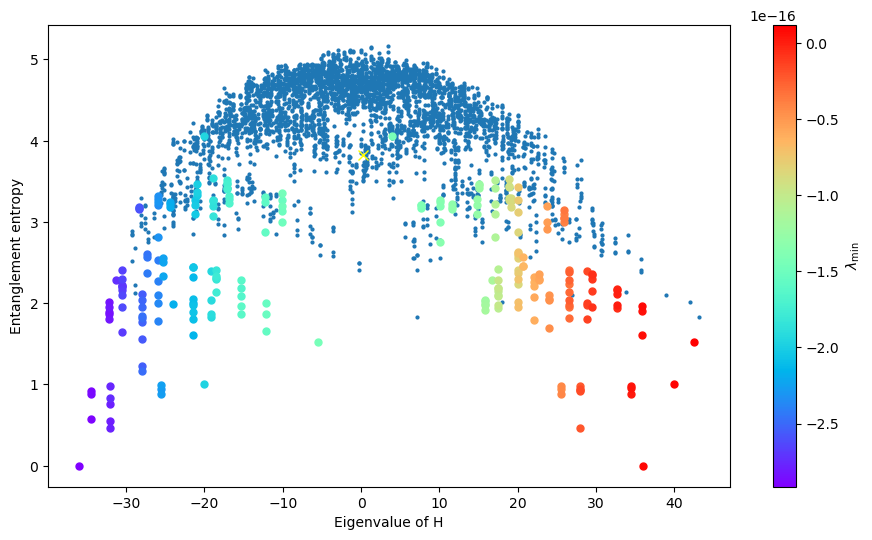

In [28]:
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(11, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues_np[idx]):.2e}, Entropy: {numpy_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(rnd_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
plt.show()

In [29]:
#################### OPTIMAL LINEAR COMBINATION OF SCARS THAT  MINIMIZE/MAXIMIZE EE ##########################

In [ ]:
# Let's look closer at the scar points with the lowest and highest entropy (Indeces: 1267, 1268)

# MIN ENTROPY

lowest_entropy_index = 1267
lowest_entropy_eigenvector = eigenvectors[:, lowest_entropy_index]
entanglement_entropy_value = entanglement_entropy(lowest_entropy_eigenvector, half, N)
print(f'Lowest Entropy Index: {lowest_entropy_index}, Entropy: {entanglement_entropy_value}')   

# Convert the eigenvector to PyTorch tensors for real and imaginary parts
params_real = torch.tensor(lowest_entropy_eigenvector.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(lowest_entropy_eigenvector.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real:", params_real)
print("Initial coeffs, imag:", params_imag)

entanglement_entropy_value = entanglement_entropy_torch(lowest_entropy_eigenvector, half, N)
print(f'Lowest Entropy Index: {lowest_entropy_index}, Entropy: {entanglement_entropy_value}')

# Define coefficients for the linear combination
min_coeffs = np.zeros(len(red_eigenvectors_np), dtype=np.complex128)  # Initialize all coefficients to 0
min_coeffs[red_indices_np.index(1267)] = 1  # Ensure the coefficient for index 1267 is explicitly set to 1


# MAX ENTROPY
highest_entropy_index = 1268
highest_entropy_eigenvector = eigenvectors[:, highest_entropy_index]
entanglement_entropy_value = entanglement_entropy(highest_entropy_eigenvector, half, N)
print(f'Highest Entropy Index: {highest_entropy_index}, Entropy: {entanglement_entropy_value}') 

# Convert the eigenvector to PyTorch tensors for real and imaginary parts
params_real = torch.tensor(lowest_entropy_eigenvector.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(lowest_entropy_eigenvector.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real:", params_real)
print("Initial coeffs, imag:", params_imag)

entanglement_entropy_value = entanglement_entropy_torch(highest_entropy_eigenvector, half, N)
print(f'Highest Entropy Index: {highest_entropy_index}, Entropy: {entanglement_entropy_value}')

# Define coefficients for the linear combination
max_coeffs = np.zeros(len(red_eigenvectors_np), dtype=np.complex128)  # Initialize all coefficients to 0
max_coeffs[red_indices_np.index(1268)] = 1  # Ensure the coefficient for index 1268 is explicitly set to 1


Lowest Entropy Index: 1267, Entropy: 4.825912844072063
Initial coeffs, real: tensor([ 0.0000e+00,  0.0000e+00, -4.8041e-18,  ..., -1.0408e-17,
         4.3368e-18,  0.0000e+00], requires_grad=True)
Initial coeffs, imag: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Lowest Entropy Index: 1267, Entropy: 4.82591438293457


ValueError: 1267 is not in list

Initial Entropy: 3.0852088928222656
Coeffs norm: 0.99999994
Entropy: 3.0852088928222656
Coeffs: [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
Coeffs norm: 0.99999994
Entropy: 2.9968011379241943
Coeffs: [-0.009998 +0.j  0.9998001+0.j -0.009998 +0.j -0.009998 +0.j
 -0.009998 +0.j]
Coeffs norm: 1.0
Entropy: 2.9056332111358643
Coeffs: [-0.0201325 +0.j  0.99918854+0.j -0.02014239+0.j -0.02013969+0.j
 -0.02014174+0.j]
Coeffs norm: 0.99999994
Entropy: 2.8122901916503906
Coeffs: [-0.03034228+0.j  0.998154  +0.j -0.03037921+0.j -0.03036996+0.j
 -0.03037742+0.j]
Coeffs norm: 0.99999994
Entropy: 2.716939926147461
Coeffs: [-0.04061408+0.j  0.9966856 +0.j -0.04070297+0.j -0.04068278+0.j
 -0.04070026+0.j]
Coeffs norm: 1.0
Entropy: 2.619765520095825
Coeffs: [-0.05093436+0.j  0.994773  +0.j -0.05110868+0.j -0.05107322+0.j
 -0.05110654+0.j]
Coeffs norm: 0.99999994
Entropy: 2.5209600925445557
Coeffs: [-0.06128766+0.j  0.9924063 +0.j -0.06159035+0.j -0.06153605+0.j
 -0.0615922 +0.j]
Coeffs norm: 1.0
Entropy: 2.42

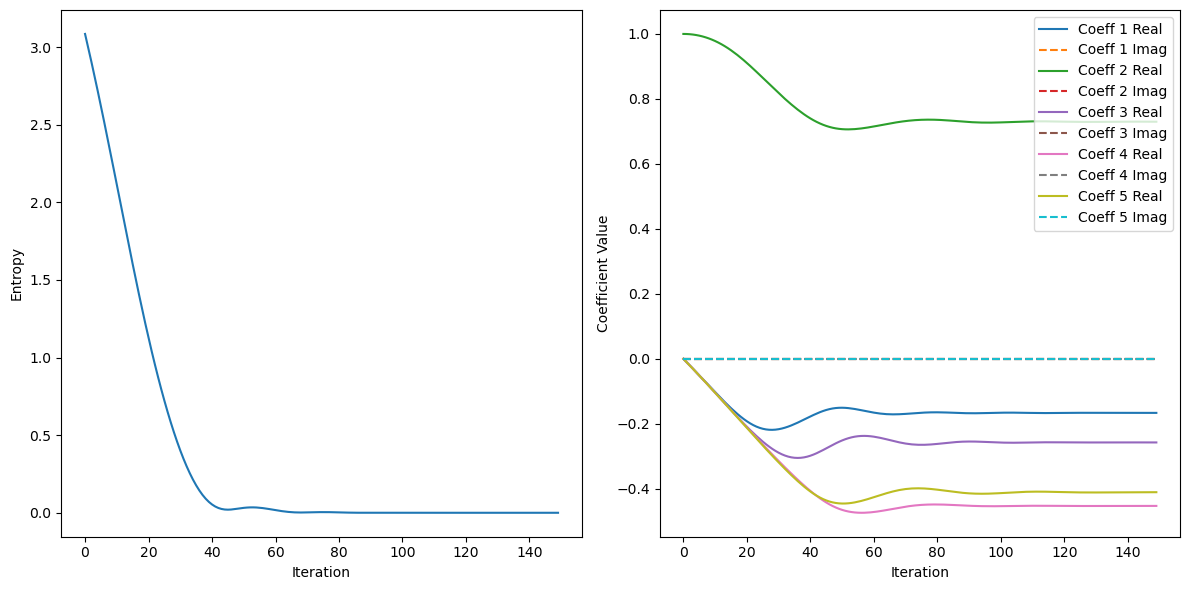

In [ ]:
# find entropy min coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

red_eigenvectors = [torch.tensor(vec, dtype=torch.complex64) for vec in red_eigenvectors_np]


params_real = torch.tensor(min_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(min_coeffs.imag, dtype=torch.float, requires_grad=True)

# Compute the linear combination using the defined function
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# if the outer products between scarred states are computed before optimization loop
# ....

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, half, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_min = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch(psi, half, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_min.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_min = np.array(coeffs_history_min)
for i in range(coeffs_history_min.shape[1]):
    plt.plot(coeffs_history_min[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_min[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248113
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Min scar entropy: 1.0277677463250409e-06


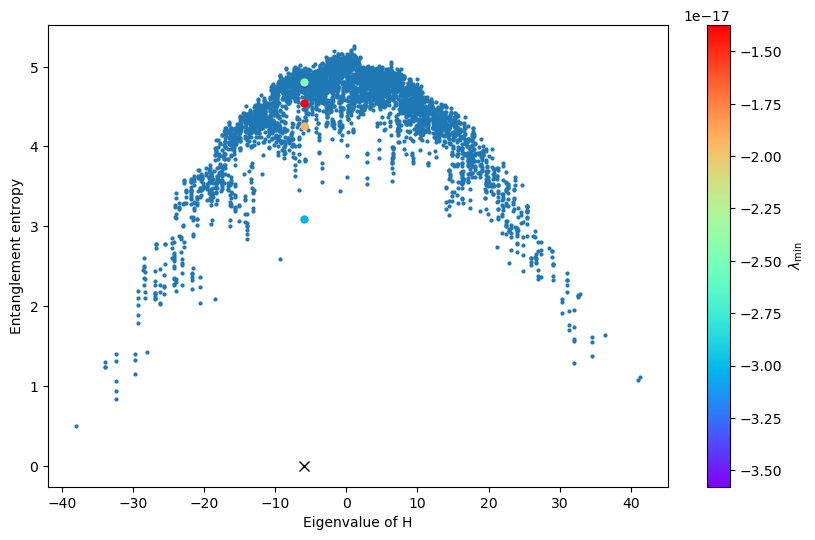

In [ ]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
min_scar = linear_combination_np(coeffs_history_min[-1], red_eigenvectors_np)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Compute entanglement entropy for the max_scar wavefunction
min_scar_entropy = entanglement_entropy(min_scar, half, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Min scar entropy: {min_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
min_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices_np]), min_scar_entropy, 'x', color='black', markersize=7)
handles.append(min_scar_handle)
labels.append('Min Scar, Entropy: {:.2f}'.format(min_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
plt.show()

Initial coeffs, real tensor([0., 0., 1., 0., 0.], requires_grad=True)
Initial coeffs imag tensor([0., 0., 0., 0., 0.], requires_grad=True)
Initial Entropy: 4.808933258056641
Coeffs norm: 0.99999994
Entropy: 4.808933258056641
Coeffs: [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
Coeffs norm: 1.0
Entropy: 4.826988220214844
Coeffs: [ 0.009998 +0.j  0.009998 +0.j  0.9998001+0.j -0.009998 +0.j
 -0.009998 +0.j]
Coeffs norm: 0.99999994
Entropy: 4.843691349029541
Coeffs: [ 0.0201411 +0.j  0.0200676 +0.j  0.99919164+0.j -0.020086  +0.j
 -0.02010537+0.j]
Coeffs norm: 1.0
Entropy: 4.858956336975098
Coeffs: [ 0.03037676+0.j  0.03009439+0.j  0.99817175+0.j -0.03016773+0.j
 -0.03024368+0.j]
Coeffs norm: 0.99999994
Entropy: 4.872756004333496
Coeffs: [ 0.04069873+0.j  0.04000148+0.j  0.9967436 +0.j -0.04018895+0.j
 -0.04038016+0.j]
Coeffs norm: 1.0
Entropy: 4.8851704597473145
Coeffs: [ 0.05110097+0.j  0.049705  +0.j  0.99491733+0.j -0.05009227+0.j
 -0.05048228+0.j]
Coeffs norm: 1.0
Entropy: 4.896269798278809
C

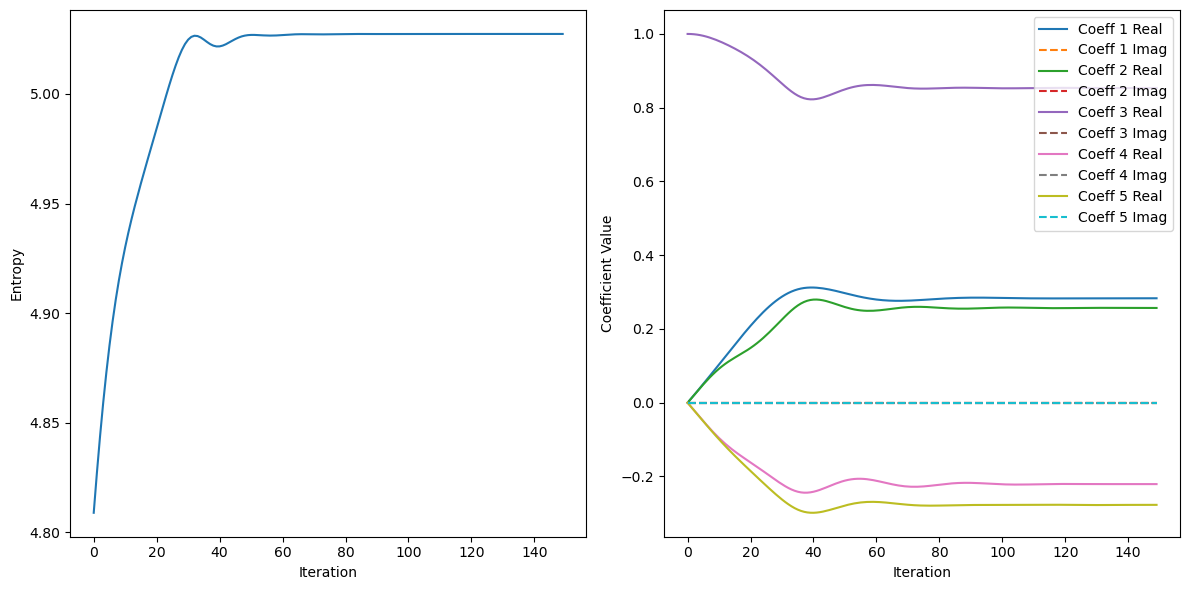

In [ ]:
# now find entropy max coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

params_real = torch.tensor(max_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(max_coeffs.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute psi
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, half, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_max = []
entropy_history_max = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute - entanglement entropy
    entropy = - entanglement_entropy_torch(psi, half, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {abs(entropy.item())}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_max.append(coeffs.detach().cpu().numpy())
    entropy_history_max.append(abs(entropy.item()))

# Final optimized coefficients
optimized_coeffs_max = torch.complex(params_real, params_imag)
optimized_coeffs_max = optimized_coeffs_max / torch.norm(optimized_coeffs_max)

print("Optimized coefficients:", optimized_coeffs_max)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(np.abs(entropy_history_max))
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_max = np.array(coeffs_history_max)
for i in range(coeffs_history_max.shape[1]):
    plt.plot(coeffs_history_max[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_max[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304961
Index: 1267, Entropy: 3.0852083789248113
Index: 1268, Entropy: 4.808932481473971
Index: 1269, Entropy: 4.254512053088167
Index: 1270, Entropy: 4.548550915890671
Max scar entropy: 5.02733191869306


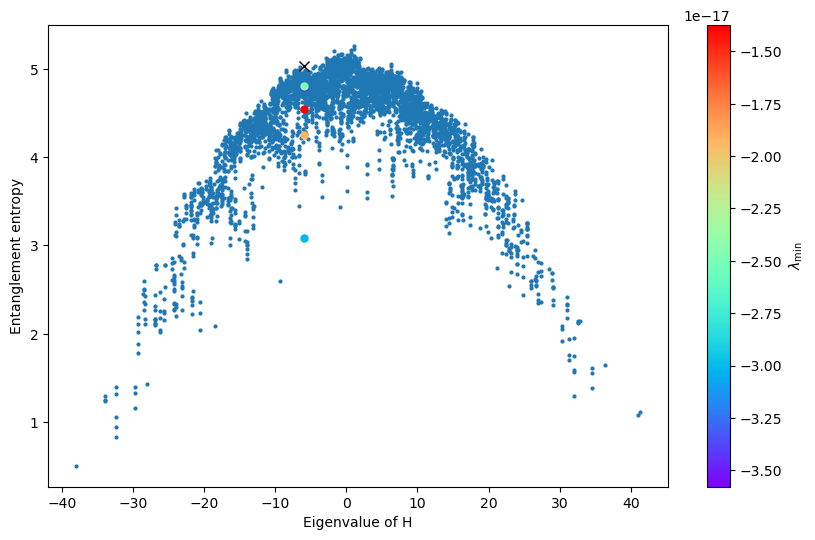

In [ ]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
max_scar = linear_combination_np(coeffs_history_max[-1], red_eigenvectors_np)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, half, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Max scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices_np]), max_scar_entropy, 'x', color='black', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

In [ ]:
################## PROPERTIES OF EACH SCARRED STATE AND THEIR RDM ######################

In [ ]:
# List to store the number of dependent columns and their indices for each matrix
dependent_columns_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Perform QR decomposition with column pivoting
    Q, R, pivot_indices = qr(rdm, pivoting=True)
    
    # Determine rank using a threshold on the diagonal of R
    tol = 1e-12
    rank = np.sum(np.abs(np.diag(R)) > tol)
    
    # Calculate the number of dependent columns
    num_dependent_columns = 16 - rank
    
    # Identify dependent columns
    dependent_columns = sorted(set(range(16)) - set(pivot_indices[:rank]))
    dependent_columns_info.append((num_dependent_columns, dependent_columns))
    
    print(f"Number of dependent columns: {num_dependent_columns}")
    print(f"Dependent columns indices: {dependent_columns}")
    print("-" * 50)

# Print the results
print("Dependent columns info for each matrix:", dependent_columns_info)

RDM Index: 0
Number of dependent columns: -2
Dependent columns indices: [0, 1, 3, 4, 7, 8, 9]
--------------------------------------------------
RDM Index: 1
Number of dependent columns: -2
Dependent columns indices: [0, 1, 2, 8, 9, 11, 12, 14]
--------------------------------------------------
RDM Index: 2
Number of dependent columns: -2
Dependent columns indices: [0, 1, 3, 4, 8, 9, 12]
--------------------------------------------------
RDM Index: 3
Number of dependent columns: -2
Dependent columns indices: [0, 1, 2, 8, 9, 10, 11]
--------------------------------------------------
RDM Index: 4
Number of dependent columns: -2
Dependent columns indices: [0, 1, 4, 6, 8, 12, 13, 14, 15]
--------------------------------------------------
Dependent columns info for each matrix: [(-2, [0, 1, 3, 4, 7, 8, 9]), (-2, [0, 1, 2, 8, 9, 11, 12, 14]), (-2, [0, 1, 3, 4, 8, 9, 12]), (-2, [0, 1, 2, 8, 9, 10, 11]), (-2, [0, 1, 4, 6, 8, 12, 13, 14, 15])]


In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        result = np.dot(rdm, basis_vector)
        print(f"RDM {idx}, Null Basis Vector {i}:")
        print(f"Result: {result}")
        print(f"Norm of Result: {np.linalg.norm(result)}")

# Print the results
print("Null space information for each matrix computed.")

RDM Index: 0
Null space dimension: 14
Null space basis vectors:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.60701921e-09 -1.00000000e+00]
 [-2.43466635e-01 -3.69572364e-01 -7.51453020e-02  9.19200951e-02
  -8.09999002e-02  7.27456146e-01  3.50564345e-05  4.12874361e-02
  -2.85934148e-01 -1.14338841e-09  4.01494138e-09 -1.17355944e-09
  -4.13313108e-01 -1.49082832e-09]
 [ 4.00856794e-01  1.10861493e-01  7.02222332e-02  1.58365313e-01
   3.97872757e-02 -2.54976839e-02 -2.69094811e-02  4.27320000e-02
  -3.27877338e-01 -7.50995807e-09  9.24738193e-10  4.93993483e-11
  -1.34384920e-01 -4.84715793e-10]
 [ 9.49850000e-02 -2.20700658e-01  7.63368890e-03 -7.89414319e-02
   1.36165335e-01 -8.26209898e-02  3.76273476e-01  2.00779032e-01
   4.93582259e-02 -1.70224988e-09 -1.48673160e-09 -2.42692940e-10
  -6.37135359e-02 -2.29905506e-10]
 [ 4

In [ ]:
# For each RDM, check if any row in its null space basis matrix is (close to) zero
for idx, rdm in enumerate(min_rdms_np):
    null_space_rdm = null_space(rdm)
    for i, row in enumerate(null_space_rdm):
        if np.allclose(row, 0, atol=1e-12):
            print(f"RDM {idx}: Row {i} in null space is (close to) zero.")

In [ ]:
# Count the number of distinct rows in the null space basis of RDM 0
rdm = min_rdms_np[4]
null_space_rdm = null_space(rdm)

# Use np.allclose to group rows that are numerically identical
distinct_rows = []
for i, row in enumerate(null_space_rdm):
    is_new = True
    for drow in distinct_rows:
        if np.allclose(row, drow, atol=1e-12):
            is_new = False
            break
    if is_new:
        distinct_rows.append(row)

print(f"Number of distinct rows in null space basis of RDM 0: {len(distinct_rows)}")

Number of distinct rows in null space basis of RDM 0: 16


In [ ]:
# Print the binary basis states for each group of identical rows in the null space basis of RDM 0 (5 spins)
# Also print the smallest row index for each group

def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

rdm = min_rdms_np[0]
null_space_rdm = null_space(rdm)

# Group row indices by their unique row (up to numerical tolerance)
groups = []
group_indices = []

for i, row in enumerate(null_space_rdm):
    found = False
    for g, grow in enumerate(groups):
        if np.allclose(row, grow, atol=1e-12):
            group_indices[g].append(i)
            found = True
            break
    if not found:
        groups.append(row)
        group_indices.append([i])

print(f"Number of distinct rows: {len(groups)}")
for indices in group_indices:
    basis_states = [index_to_binary(idx, 5) for idx in indices]
    min_row = min(indices)
    print(f"Row {min_row}: Basis states: {', '.join(basis_states)}")

Number of distinct rows: 16
Row 0: Basis states: 00000
Row 1: Basis states: 00001
Row 2: Basis states: 00010, 00100, 10000
Row 3: Basis states: 00011, 00101, 10001
Row 6: Basis states: 00110, 10010, 10100
Row 7: Basis states: 00111, 10011, 10101
Row 8: Basis states: 01000
Row 9: Basis states: 01001
Row 10: Basis states: 01010, 01100, 11000
Row 11: Basis states: 01011, 01101, 11001
Row 14: Basis states: 01110, 11010, 11100
Row 15: Basis states: 01111, 11011, 11101
Row 22: Basis states: 10110
Row 23: Basis states: 10111
Row 30: Basis states: 11110
Row 31: Basis states: 11111


In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    #print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    #for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        #result = np.dot(rdm, basis_vector)
        #print(f"RDM {idx}, Null Basis Vector {i}:")
        #print(f"Result: {result}")
        #print(f"Norm of Result: {np.linalg.norm(result)}")
    
    # Check for repeating rows in the null space basis vectors
    print(f"Repeating rows in the null space basis vectors for RDM {idx}:")
    for i in range(null_space_rdm.shape[0]):
        for j in range(i + 1, null_space_rdm.shape[0]):
            if np.allclose(null_space_rdm[i, :], null_space_rdm[j, :], atol=1e-12):  # Compare rows with a tolerance
                print(f"Row {i} is identical to Row {j}")
    print("-" * 50)

RDM Index: 0
Null space dimension: 14
--------------------------------------------------
Repeating rows in the null space basis vectors for RDM 0:
Row 2 is identical to Row 4
Row 2 is identical to Row 16
Row 3 is identical to Row 5
Row 3 is identical to Row 17
Row 4 is identical to Row 16
Row 5 is identical to Row 17
Row 6 is identical to Row 18
Row 6 is identical to Row 20
Row 7 is identical to Row 19
Row 7 is identical to Row 21
Row 10 is identical to Row 12
Row 10 is identical to Row 24
Row 11 is identical to Row 13
Row 11 is identical to Row 25
Row 12 is identical to Row 24
Row 13 is identical to Row 25
Row 14 is identical to Row 26
Row 14 is identical to Row 28
Row 15 is identical to Row 27
Row 15 is identical to Row 29
Row 18 is identical to Row 20
Row 19 is identical to Row 21
Row 26 is identical to Row 28
Row 27 is identical to Row 29
--------------------------------------------------
RDM Index: 1
Null space dimension: 14
--------------------------------------------------
Repea

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    # Print the entire eigenvector
    non_zero_count = 0  # Counter for non-zero components
    print(f"Full Eigenvector {i}:")
    for index, component in enumerate(eigenvector):
        # Set components of the order 10^-12 or smaller to zero
        if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
            eigenvector[index] = 0.0
        else:
            non_zero_count += 1
        binary_basis = index_to_binary(index, N)
        print(f"{binary_basis}: {eigenvector[index]}")

    print(f"Total Non-Zero Components in Scarred Eigenvector {i}: {non_zero_count}")
    print("=" * 50)

Full Eigenvector 0:
000000000000: 0.0
000000000001: 0.0
000000000010: 0.0
000000000011: 0.0
000000000100: 0.0
000000000101: 0.0
000000000110: 0.0
000000000111: 0.0
000000001000: 0.0
000000001001: 0.0
000000001010: 0.0
000000001011: 0.0
000000001100: 0.0
000000001101: 0.0
000000001110: 0.0
000000001111: 0.0
000000010000: 0.0
000000010001: 0.0
000000010010: 0.0
000000010011: 0.0
000000010100: 0.0
000000010101: 0.0
000000010110: 0.0
000000010111: 0.0
000000011000: 0.0
000000011001: 0.0
000000011010: 0.0
000000011011: 0.0
000000011100: 0.0
000000011101: 0.0
000000011110: 0.0
000000011111: 0.0
000000100000: 0.0
000000100001: 0.0
000000100010: 0.0
000000100011: 0.0
000000100100: 0.0
000000100101: 0.0
000000100110: 0.0
000000100111: 0.0
000000101000: 0.0
000000101001: 0.0
000000101010: 0.0
000000101011: 0.0
000000101100: 0.0
000000101101: 0.0
000000101110: 0.0
000000101111: 0.0
000000110000: 0.0
000000110001: 0.0
000000110010: 0.0
000000110011: 0.0
000000110100: 0.0
000000110101: 0.0
00000011

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")
    
    # Dictionary to track processed coefficients
    processed_coeffs = set()
    
    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component
            
            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue
            
            # Count the number of 1's in the binary representation
            num_ones = binary_basis.count('1')
            
            # Print the coefficient, binary representation, and number of 1's
            print(f"  Coefficient: {coeff}")
            print(f"    Binary Representation: {binary_basis}")
            print(f"    Elements [0, 4, 5, 9]: {binary_basis[0]}, {binary_basis[4]}, {binary_basis[5]}, {binary_basis[9]}")
            print(f"    Number of 1's: {num_ones}")
            
            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)
                    num_ones_neg = binary_basis_neg.count('1')
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Elements [0, 4, 5, 9]: {binary_basis_neg[0]}, {binary_basis_neg[4]}, {binary_basis_neg[5]}, {binary_basis_neg[9]}")
                    print(f"    Number of 1's: {num_ones_neg}")
                    break
            
            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)
    
    print("=" * 50)

Scarred Eigenvector 0:
  Coefficient: 0.036079859503819985
    Binary Representation: 000001101111
    Elements [0, 4, 5, 9]: 0, 0, 1, 1
    Number of 1's: 6
  Negative Coefficient: -0.036079859503819985
    Binary Representation: 011011000101
    Elements [0, 4, 5, 9]: 0, 1, 1, 1
    Number of 1's: 6
  Coefficient: -0.04036692166496487
    Binary Representation: 000001111011
    Elements [0, 4, 5, 9]: 0, 0, 1, 0
    Number of 1's: 6
  Negative Coefficient: 0.04036692166496487
    Binary Representation: 000101111010
    Elements [0, 4, 5, 9]: 0, 0, 1, 0
    Number of 1's: 6
  Coefficient: 0.004287062161162862
    Binary Representation: 000001111110
    Elements [0, 4, 5, 9]: 0, 0, 1, 1
    Number of 1's: 6
  Negative Coefficient: -0.004287062161162862
    Binary Representation: 000100111110
    Elements [0, 4, 5, 9]: 0, 0, 0, 1
    Number of 1's: 6
  Coefficient: -0.03305628749541412
    Binary Representation: 000010011111
    Elements [0, 4, 5, 9]: 0, 1, 0, 1
    Number of 1's: 6
  Ne

In [ ]:
# List to store even swaps numbers
even_swaps_numbers = []

# Dictionary to track spin exchange arrays and their counts
spin_exchange_counts = {}

# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")

    # Dictionary to track processed coefficients
    processed_coeffs = set()

    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component

            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue

            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)

                    # Identify the spins that are exchanged
                    spin_exchange = [
                        k for k in range(N) if binary_basis[k] != binary_basis_neg[k]
                    ]

                    # Compute swaps number
                    swaps_number = len(spin_exchange) // 2

                    # Check if swaps number is odd
                    is_odd = swaps_number % 2 == 1

                    print(f"  Coefficient: {coeff}")
                    print(f"    Binary Representation: {binary_basis}")
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Spin Exchange: {spin_exchange}")
                    print(f"    Swaps Number: {swaps_number} (Odd: {is_odd})")

                    # Add to even swaps numbers if swaps number is even
                    if not is_odd:
                        even_swaps_numbers.append(swaps_number)

                    # Track spin exchange arrays
                    spin_exchange_tuple = tuple(spin_exchange)
                    if spin_exchange_tuple in spin_exchange_counts:
                        spin_exchange_counts[spin_exchange_tuple] += 1
                    else:
                        spin_exchange_counts[spin_exchange_tuple] = 1

                    break

            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)

    print("=" * 50)

# Print the list of even swaps numbers
print("Even swaps numbers:", even_swaps_numbers)

# Check for repeated spin exchange arrays
repeated_spin_exchanges = [
    spin_exchange for spin_exchange, count in spin_exchange_counts.items() if count > 1
]
if repeated_spin_exchanges:
    print("Repeated spin exchange arrays:", repeated_spin_exchanges)
else:
    print("No repeated spin exchange arrays found.")

print(len(spin_exchange_counts), "spin exchange arrays found.")

Scarred Eigenvector 0:
  Coefficient: 0.036079859503819985
    Binary Representation: 000001101111
  Negative Coefficient: -0.036079859503819985
    Binary Representation: 011011000101
    Spin Exchange: [1, 2, 4, 6, 8, 10]
    Swaps Number: 3 (Odd: True)
  Coefficient: -0.04036692166496487
    Binary Representation: 000001111011
  Negative Coefficient: 0.04036692166496487
    Binary Representation: 000101111010
    Spin Exchange: [3, 11]
    Swaps Number: 1 (Odd: True)
  Coefficient: 0.004287062161162862
    Binary Representation: 000001111110
  Negative Coefficient: -0.004287062161162862
    Binary Representation: 000100111110
    Spin Exchange: [3, 5]
    Swaps Number: 1 (Odd: True)
  Coefficient: -0.03305628749541412
    Binary Representation: 000010011111
  Negative Coefficient: 0.03305628749541412
    Binary Representation: 011011001010
    Spin Exchange: [1, 2, 5, 7, 9, 11]
    Swaps Number: 3 (Odd: True)
  Coefficient: -0.06716907787316732
    Binary Representation: 00001011011

In [ ]:
# min_scar

non_zero_count = 0  # Counter for non-zero components

for index, component in enumerate(min_scar):
    # Set components of the order 10^-12 or smaller to zero
    if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
        min_scar[index] = 0.0
    else:
        non_zero_count += 1
    binary_basis = index_to_binary(index, N)
    print(f"{binary_basis}: {np.real(min_scar[index])}")

print(f"Total Non-Zero Components in min_scar: {non_zero_count}")
print("=" * 50)

000000000000: 0.0
000000000001: 0.0
000000000010: 0.0
000000000011: 0.0
000000000100: 0.0
000000000101: 0.0
000000000110: 0.0
000000000111: 0.0
000000001000: 0.0
000000001001: 0.0
000000001010: 0.0
000000001011: 0.0
000000001100: 0.0
000000001101: 0.0
000000001110: 0.0
000000001111: 0.0
000000010000: 0.0
000000010001: 0.0
000000010010: 0.0
000000010011: 0.0
000000010100: 0.0
000000010101: 0.0
000000010110: 0.0
000000010111: 0.0
000000011000: 0.0
000000011001: 0.0
000000011010: 0.0
000000011011: 0.0
000000011100: 0.0
000000011101: 0.0
000000011110: 0.0
000000011111: 0.0
000000100000: 0.0
000000100001: 0.0
000000100010: 0.0
000000100011: 0.0
000000100100: 0.0
000000100101: 0.0
000000100110: 0.0
000000100111: 0.0
000000101000: 0.0
000000101001: 0.0
000000101010: 0.0
000000101011: 0.0
000000101100: 0.0
000000101101: 0.0
000000101110: 0.0
000000101111: 0.0
000000110000: 0.0
000000110001: 0.0
000000110010: 0.0
000000110011: 0.0
000000110100: 0.0
000000110101: 0.0
000000110110: 0.0
0000001101

In [ ]:
# check if other states have 280 non-zero components - it's only the 5 scars!

# Count distinct non_zero_count values
distinct_counts = set()

# Counter to track occurrences of each non_zero_count
non_zero_count_occurrences = Counter()

# Iterate over all eigenvectors
for i in range(eigenvectors.shape[1]):
    eigenvector = eigenvectors[:, i]
    non_zero_count = 0  # Counter for non-zero components
    
    # Count non-zero components
    for component in eigenvector:
        if np.abs(component) >= 1e-12:
            non_zero_count += 1
    
    # Update the counter
    non_zero_count_occurrences[non_zero_count] += 1
    print(f"Total Non-Zero Components in Eigenvector {i}: {non_zero_count}")

# Print the number of distinct non_zero_count values
print(f"Number of distinct non_zero_count values: {len(non_zero_count_occurrences)}")
print(f"Distinct non_zero_count values: {sorted(non_zero_count_occurrences.keys())}")

# Print how many times each distinct non_zero_count appears
print("Occurrences of each non_zero_count:")
for count, occurrences in sorted(non_zero_count_occurrences.items()):
    print(f"Non-Zero Count: {count}, Occurrences: {occurrences}")

Total Non-Zero Components in Eigenvector 0: 2048
Total Non-Zero Components in Eigenvector 1: 2048
Total Non-Zero Components in Eigenvector 2: 2048
Total Non-Zero Components in Eigenvector 3: 2048
Total Non-Zero Components in Eigenvector 4: 2048
Total Non-Zero Components in Eigenvector 5: 2048
Total Non-Zero Components in Eigenvector 6: 2048
Total Non-Zero Components in Eigenvector 7: 2048
Total Non-Zero Components in Eigenvector 8: 2048
Total Non-Zero Components in Eigenvector 9: 2048
Total Non-Zero Components in Eigenvector 10: 2048
Total Non-Zero Components in Eigenvector 11: 2048
Total Non-Zero Components in Eigenvector 12: 2046
Total Non-Zero Components in Eigenvector 13: 2046
Total Non-Zero Components in Eigenvector 14: 2046
Total Non-Zero Components in Eigenvector 15: 2046
Total Non-Zero Components in Eigenvector 16: 2046
Total Non-Zero Components in Eigenvector 17: 2048
Total Non-Zero Components in Eigenvector 18: 1920
Total Non-Zero Components in Eigenvector 19: 1920
Total Non-

In [ ]:
'''#find a 4/5 spins charge commuting with the rdm - let's first use quantum channel to derive the effective action of the global C5 symmetry operator on the 4 spins subsystem:

##   rho4' = Tr_8[C5 (rho4 cross rho8) C5^dagger], and compare it to rho4
##   C5^4 = Tr_8[C5 (I4 cross rho8)] --- not sure if this is correct, but let's try it anyway

# let's first find rho8 - we already have rho4 and C5=P

###### USELESS ############

# Compute RDM on the complement of keep_qubits for scarred eigenstates
complement_rdms = []  # List to store RDMs on the complement of keep_qubits

# Define the complement of keep_qubits
all_qubits = set(range(N))
for i in red_indices_np:
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Complement of keep_qubits
    complement_qubits = list(all_qubits - set(keep_qubits))

    # Trace out the complement qubits
    traced_out_complement = ptrace(density_matrix_qobj, complement_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_complement_dense = traced_out_complement.full()
    complement_rdms.append(traced_out_complement_dense)

    # Compute the trace of the complement RDM
    trace_value = np.trace(traced_out_complement_dense)

    # Check if the complement RDM is Hermitian
    is_hermitian = np.allclose(traced_out_complement_dense, traced_out_complement_dense.conj().T)

    # Print the results for debugging
    print(f"Complement RDM for eigenstate {i}:")
    print(f"Shape: {traced_out_complement_dense.shape}")
    print(f"Trace: {trace_value}")
    print(f"Is Hermitian: {is_hermitian}")
    print("-" * 50)

# Now `complement_rdms` contains the RDMs on the complement of keep_qubits for all scarred eigenstates

# full P=C5

P = dok_matrix((2**N, 2**N), dtype=np.float64)

# Go through all basis states
for index in range(2**N):
    # Convert index to spin bits
    state_bits = list(map(int, np.binary_repr(index, width=N)))
    
    # Apply the permutation
    new_bits = apply_permutation(state_bits, N, perm)
    
    # Convert back to integer index
    new_index = int("".join(map(str, new_bits)), 2)
    
    # Set the permutation matrix entry
    P[new_index, index] = 1.0

# Optionally convert to CSR format for efficient multiplication
P = P.toarray()

print("Permutation matrix P constructed with shape:", P.shape)

# first attempt for the effective 4-spins operator C5^4

C5_4s = []

P_qobj = Qobj(P, dims=[[2]*N, [2]*N])


for i in range(len(complement_rdms)):
    rho8 = complement_rdms[i]
    # Convert rho8 (NumPy matrix) back to Qobj
    rho8_qobj = Qobj(rho8, dims=[[2] * (N - len(keep_qubits)), [2] * (N - len(keep_qubits))])

    # Define subsystem dimensions
    dim_A = 2**(len(keep_qubits))   # e.g., 4 spins → dimension 16
    dim_B = rho8_qobj.dims[0][0]  # This should be 2**(N-4) for N spins total

    # Identity on subsystem A
    IA_qobj = qeye(dim_A)
    IA = np.eye(dim_A, dtype=np.float64)  # Identity matrix for subsystem A

    # Build the product state (I_A ⊗ rhoB)
    #IA_rho8 = tensor(IA, rho8_qobj)
    IA_rho8 = np.kron(IA, rho8)  # Kronecker product of I_A and rhoB
    IA_rho8_qobj = Qobj(IA_rho8, dims=[[2] * N, [2] * N])

    # Print dimensions
    print(f"Dimension of IA: {IA.shape}")
    print(f"Dimension of rho8_qobj: {rho8.shape}")
    print(f"Dimension of IA_rho8: {IA_rho8_qobj.dims}")

    # Apply global C5 (P) to this state
    U_rho = P_qobj * IA_rho8_qobj

    # Partial trace over subsystem B → result acts on subsystem A
    # If A is the first subsystem in the tensor product, trace out B (which is subsystem 1)
    #C5_4 = ptrace(U_rho, 0)  # 0 → subsystem A (remaining after tracing out B)
    C5_4 = ptrace(U_rho, keep_qubits)  # Trace out the complement of keep_qubits

    # Now C5_tilde is the effective operator acting on subsystem A (4 spins)
    C5_4s.append(C5_4.full())  # Convert to dense matrix if needed
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4.shape}")

for i in range(len(C5_4s)):
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4s[i].shape}")
    print(C5_4s[i])
    print("-" * 50)

# Compute commutators between each C5_4 and the corresponding rho4
commutators = []

for i in range(len(C5_4s)):
    # Convert rho4 (min_rdms) to a dense matrix if needed
    rho4 = min_rdms_np[i]  # Corresponding reduced density matrix (rho4)
    C5_4 = C5_4s[i]     # Corresponding effective operator (C5_4)

    # Compute the commutator: [C5_4, rho4] = C5_4 * rho4 - rho4 * C5_4
    commutator = np.dot(C5_4, rho4) - np.dot(rho4, C5_4)
    commutators.append(commutator)

    # Print the commutator for debugging
    print(f"Commutator for scar {i}:")
    print(commutator)
    print(f"Norm of commutator: {np.linalg.norm(commutator)}")
    print("-" * 50)

# Now `commutators` contains the commutators for all eigenstates

rho4Us = []

for i in range(len(complement_rdms)):

    rho4 = min_rdms_np[i]
    # Convert rho4 (NumPy matrix) back to Qobj
    rho4_qobj = Qobj(rho4, dims=[[2] * (len(keep_qubits)), [2] * (len(keep_qubits))])

    rho8 = complement_rdms[i]
    # Convert rho8 (NumPy matrix) back to Qobj
    rho8_qobj = Qobj(rho8, dims=[[2] * (N - len(keep_qubits)), [2] * (N - len(keep_qubits))])

    # Build the product state (rhoA ⊗ rhoB)
    rho4_rho8 = np.kron(rho4, rho8)  # Kronecker product of rhoA and rhoB
    rho4_rho8_qobj = Qobj(rho4_rho8, dims=[[2] * N, [2] * N])

    # Apply C5 and its adjoint to this state
    U_rho_U = P_qobj * rho4_rho8_qobj * (P_qobj).dag()

    # Partial trace over subsystem B → result acts on subsystem A
    rho4U = ptrace(U_rho_U, keep_qubits)  # Trace out the complement of keep_qubits

    # rho4U is the 4 spins rdm after effective action of C5 on subsystem A (4 spins)
    rho4U_dense = rho4U.full()  # Convert to dense matrix if needed
    rho4Us.append(rho4U_dense)

    # Check trace
    trace_value = np.trace(rho4U_dense)
    print(f"Trace of rho4U for eigenstate {i}: {trace_value}")

    # Check if Hermitian
    is_hermitian = np.allclose(rho4U_dense, rho4U_dense.conj().T)
    print(f"Is rho4U Hermitian for eigenstate {i}: {is_hermitian}")

    print(f"rho4U for eigenstate {i}:")
    print(f"Shape: {rho4U_dense.shape}")
    print("-" * 50)


for i in range(len(rho4Us)):
    norm_rho4U = np.linalg.norm(rho4Us[i], ord='fro')  # Frobenius norm
    print(f"Norm of rho4U for eigenstate {i}: {norm_rho4U}")
    norm_rho4 = np.linalg.norm(min_rdms_np[i], ord='fro')  # Frobenius norm
    print(f"Norm of rho4 for eigenstate {i}: {norm_rho4}")
    distance = np.linalg.norm(rho4Us[i] - min_rdms_np[i], ord='fro')  # Frobenius norm
    print(f"Distance between rho4U and rho4 for eigenstate {i}: {distance}")'''

'#find a 4/5 spins charge commuting with the rdm - let\'s first use quantum channel to derive the effective action of the global C5 symmetry operator on the 4 spins subsystem:\n\n##   rho4\' = Tr_8[C5 (rho4 cross rho8) C5^dagger], and compare it to rho4\n##   C5^4 = Tr_8[C5 (I4 cross rho8)] --- not sure if this is correct, but let\'s try it anyway\n\n# let\'s first find rho8 - we already have rho4 and C5=P\n\n###### USELESS ############\n\n# Compute RDM on the complement of keep_qubits for scarred eigenstates\ncomplement_rdms = []  # List to store RDMs on the complement of keep_qubits\n\n# Define the complement of keep_qubits\nall_qubits = set(range(N))\nfor i in red_indices_np:\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Complement of keep_qubits\n    complement_qubits = list(all_qubits - set(keep_qubits))\n\n    # Trace out the complement